# PD 3 
## Piotr Fic
### Import bibliotek

In [1]:
import numpy as np
from numpy import random
import math
import pandas as pd
import matplotlib.pyplot as plt

## Funkcje pomocnicze

In [2]:
def predicted_real(predicted, real):
    plt.scatter(real, predicted, c='blue')
    p1 = max(max(predicted), max(real))
    p2 = min(min(predicted), min(real))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True values')
    plt.ylabel('Predictions')
    plt.title('Predictions visualization on test set')
    plt.axis('equal')
    plt.show()
    
def sigmoid(x):
    "Stabilna funkcja sigmoidalna"""
    if x >= 0:
        z = np.exp(-x)
        return 1 / (1 + z)
    else:
        z = np.exp(x)
        return z / (1 + z)
sigmoid = np.vectorize(sigmoid)

def sigmoid_der(x):
    """Pochodna funkcji sigmoidalnej"""
    return sigmoid(x)*(1-sigmoid(x))
sigmoid_der = np.vectorize(sigmoid_der)

def MSE(predicted, real):
    return np.mean((predicted - real)**2)

def MAE(predicted, real):
    return np.mean(np.abs(predicted - real))

def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def prepear_data(df_train, df_test):
    #Separacja wektorów cech i odpowiedzi
    x_train, x_test = df_train.iloc[:, 1], df_test.iloc[:, 1]
    x_train, x_test = np.array(x_train), np.array(x_test)
    #Implementacja wymaga "pionowego" wektora cech
    x_train.shape = (len(x_train), 1)
    x_test.shape = (len(x_test), 1)
    y_train, y_test = np.array(df_train.iloc[:, 2:3]), np.array(df_test.iloc[:, 2:3])
    #Normalizacja
    x_train, x_test = normalize(x_train), normalize(x_test)
    y_train, y_test = normalize(y_train), normalize(y_test)
    #Transpozycja
    x_train = x_train.reshape(1, -1)
    y_train = y_train.reshape(1,-1)
    x_test = x_test.reshape(1,-1)
    y_test = y_test.reshape(1,-1)
    return x_train, y_train, x_test, y_test


## Rozszerzenie implementacji MLP
 - częściowo zmieniony algorytm propagacji błędu w celu skorzystania z efektywniejszych operacji macierzowych dla całego batcha treningowego
 - wprowadzenie momentum (parametr "l_m") i RSMProp (parametr "beta")
 - domyślne wartości powyższych parametrów ustawione są na 0, mamy wtedy klasyczną wersję MLP

In [3]:
class Layer:
        
    def __init__(self, 
                 #Liczba neuronów w poprzedzającej i kolejnej warstwie
                 input_size: int, 
                 output_size: int,
                 #Domyślna funkcja aktywacyjna i jej pochodna                 
                 activation_fun = sigmoid, 
                 activation_fun_der = sigmoid_der,
                 #Parametry rozkładu jednostajnego dla losowych wag
                 lb = -1,
                 ub = 1,
                 #Możliwe do ustawienia wagi i bias-y
                 weights = None, 
                 biases = None):
        
        #Domyślne losowo wygenerowane wagi i bias-y jeśli nie zostały podane
        d_weights = random.uniform(lb, ub, size = (output_size, input_size))
        d_biases = random.uniform(lb, ub, size = (output_size, 1))
        
        #Wagi dla wszystkich neuronów z warstwy 
        self.weights = weights if weights is not None else d_weights
        
        #Stałe "b"
        self.biases = biases if biases is not None else d_biases
        
        #Funkcja aktywacji i jej pochodna
        self.activation_fun = activation_fun
        self.activation_fun_der = activation_fun_der
    
    def predict(self, input):
        #Przekształca input z poprzedniej warstwy przez wagi i funkcję aktywacji 
        #Zwraca output do przekazania kolejnej warstwie
        return self.activation_fun(self.weights@input + self.biases)
    
    def forward(self, input):
        #Przekształca input z poprzedniej warstwy jedynie przez wagi
        return self.weights@input + self.biases

In [4]:
class Network:
    
    def __init__(self, layers: list):
        
        #Warstwy
        self.layers = layers
        self.momentum_w = [np.zeros(l.weights.shape) for l in layers]
        self.momentum_b = [np.zeros(l.biases.shape) for l in layers]
        self.g_w = [np.zeros(l.weights.shape) for l in layers]
        self.g_b = [np.zeros(l.biases.shape) for l in layers]
        
    def predict(self, X):
        """Oblicza output na podstawie danych i parametrów warstw"""
        output = X
        for layer in self.layers:
            output = layer.predict(output)
        return output
    
    def forward(self, X):
        """Pełna metoda feedforward
        return: sumy, aktywacje"""
        sums = []
        activations = [X]
        activations_layer = X
        for layer in self.layers:
            sums_layer = layer.forward(activations_layer)
            sums.append(sums_layer)
            
            activations_layer = layer.activation_fun(sums_layer)
            activations.append(activations_layer)
            
        return sums, activations
    
    def backprop(self, X, Y):
        """Propagacja wsteczna błędu
        return: gradienty MSE"""
        
        #Wyliczenie feedforward obecnymi parametrami
        sums, activations = self.forward(X)
        
        #Macierze na poprawki parametrów
        delta_biases = []
        delta_weights = []
        
        n_layers = len(self.layers)
        err = [None]*n_layers
        #Wyliczenie err ostatniej warstwy
        err[-1] = (Y - activations[-1])*self.layers[-1].activation_fun_der(sums[-1])
        
        #Wyliczenie gradientu MSE po parametrach ostatniej warstwy
        #delta_biases[-1] = err
        #delta_weights[-1] = activations[-2].transpose()@err
        
        #Propagacja wsteczna
        for i in range(n_layers-2, -1, -1):
            act_f_der = self.layers[i].activation_fun_der(sums[i])
            err[i] = (self.layers[i+1].weights.transpose()@err[i+1]) * act_f_der 
            
        #Batch size
        batch_size = Y.shape[1]
        delta_biases = [e@np.ones((batch_size, 1))/float(batch_size) 
                              for e in err]
        delta_weights = [np.dot(e, activations[i].transpose())/float(batch_size) 
                        for i, e in enumerate(err)]
        
        return delta_biases, delta_weights
    
    def train(self, X, Y, 
              batch_size = 1, 
              etha = 0.001, 
              tol = 10**(-6), 
              n_iter = 500, 
              #Lambda dla momentum
              l_m = 0,
              #Beta dla RMSProp
              beta = 1,
              verbose = False):
        """Wytrenowuje sieć wybraną metodą minimalizując MSE 
        na zbiorze walidacyjnym
        return: liczba epok (na potrzeby porównań)"""
        if(batch_size==1):
            algorithm = self.gd
        else:
            algorithm = self.batch_gd
            
        
        #Losowość przed podziałem zbioru, ziarno zapewnia identyczną permutację
        #w zmiennych objaśnających i zmiennej celu
        X = np.copy(x_train)
        Y = np.copy(y_train)
        random.RandomState(42).shuffle(X)
        random.RandomState(42).shuffle(Y)

        #Podział zbioru na część walidacyjną i treningową
        #proporcje: val 20% - train 80%
        X_split = np.split(X, [int(.8 * X.shape[1])], axis=1)
        X_train, X_val = X_split[0], X_split[1]

        Y_split = np.split(Y, [int(.8 * Y.shape[1])], axis=1)
        Y_train, Y_val = Y_split[0], Y_split[1]
        
        #Właściwe trenowanie sieci
        current_mse = np.inf
        new_mse = MSE(self.predict(X_val), Y_val)
        it = 1
        while True:
            #Wywołanie konkretnego algorytmu
            algorithm(X_train, Y_train, batch_size, etha, l_m, beta)
            new_mse = MSE(self.predict(X_val), Y_val)
            
            #Wizualizacja procesu uczenia
            if(verbose):
                print("Epoche " + str(it) + " finished")
                print("Current MSE on validation set:")
                print(new_mse)
                for i in range(len(self.layers)):
                    print("Warstwa " + str(i) + " wagi:")
                    print(self.layers[i].weights)
                    print("Warstwa " + str(i) + " bias-y:")
                    print(self.layers[i].biases)
                print("\n")
            
            it += 1
            if(it == n_iter):
                break
            elif(current_mse - new_mse > tol):
                current_mse = new_mse
            else:
                break
            
        return it
    
    def gd(self, X, Y, etha, l_m, beta):
        """Trening sieci podstawową metodą Gradient Descent"""
        b, w = self.backprop(X, Y)
        for i in range(len(self.layers)):
            #Aktualizacja momentum
            self.momentum_w[i] = w[i]+l_m*self.momentum_w[i]
            self.momentum_b[i] = b[i]+l_m*self.momentum_b[i]
            
            #Aktualizacja RMSProp
            self.g_w[i] = (1-beta)*w[i]*w[i]+beta*self.g_w[i]
            self.g_b[i] = (1-beta)*b[i]*b[i]+beta*self.g_b[i]
        
            l = self.layers[i]
            if(beta):
                l.biases = l.biases + etha*self.momentum_b[i] + (etha*b[i])/np.sqrt(0.00001+self.g_b[i]) 
                l.weights = l.weights + etha*self.momentum_w[i] + (etha*w[i])/np.sqrt(0.00001+self.g_w[i])
            else:
                l.biases = l.biases + etha*self.momentum_b[i]
                l.weights = l.weights + etha*self.momentum_w[i]
            
        return
    
    def batch_gd(self, X, Y, batch_size, etha, l_m, beta):
        """Trening sieci metodą Mini-batch Gradient Descent"""
        #Metoda train uprzednio dokonuje permutacji zbioru
        #Wywołanie metody gradient descent na kolejnych batch-ach
        i=0
        while(i<len(Y)):
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            i += batch_size
            self.gd(x, y, etha, l_m, beta)
        return
        

## Eksperyment porównawczy
Zbiory danych: 3 podane w treści PD.

In [5]:
df1_train = pd.read_csv("./mio1/regression/square-large-training.csv")
df1_test = pd.read_csv("./mio1/regression/square-large-test.csv")

df2_train = pd.read_csv("./mio1/regression/steps-large-training.csv")
df2_test = pd.read_csv("./mio1/regression/steps-large-test.csv")

df3_train = pd.read_csv("./mio1/regression/multimodal-large-training.csv")
df3_test = pd.read_csv("./mio1/regression/multimodal-large-test.csv")

### Architektury sieci
 - 1x warstwa ukryta (5 neuronów)
 - 1x warstwa ukryta (10 neuronów)

In [6]:
#Te same koncepcje co w PD1-PD2
#Architektura 1
def arch1(lb = -1, ub = 1):
    l1_1 = Layer(input_size=1, output_size=5, lb = -1, ub = 1)
    l1_2 = Layer(input_size=5, output_size=1, lb = -1, ub = 1, 
               activation_fun= lambda x: x, 
               activation_fun_der= lambda x: 1)          
    return Network([l1_1, l1_2])
    
#Architektura 2
def arch2(lb = -1, ub = 1):
    l2_1 = Layer(1, 10, lb = -1, ub = 1)
    l2_2 = Layer(10, 1, lb = -1, ub = 1, 
                 activation_fun= lambda x: x, 
                 activation_fun_der= lambda x: 1)
    return Network([l2_1, l2_2])

In [18]:
data_train = [df1_train, df2_train, df3_train]
data_test = [df1_test, df2_test, df3_test]

### Obliczenia
 - ograniczenie liczby epok do niższej niż zwykle: 100
 - wytrenowanie sieci na zbiorach i obliczenie MSE na części testowej
 - spodziewane wyniki: wykorzystanie momentum i RMSProp powinno skutkować osiągnięciem lepszego dopasowania szybciej niż przy klasycznym MLP, czyli przy założonych 100 epokach spodziewamy się niższego MSE

In [24]:
r1 = np.zeros((3, 3))
r2 = np.zeros((3, 3))

j = 0
for df_train, df_test in zip(data_train, data_test):
    x_train, y_train, x_test, y_test = prepear_data(df_train, df_test)
    #Wykonam po n procesów trenowania sieci i uśrednię liczbę epok
    n = 2
    ep1 = np.zeros((n, 3))
    ep2 = np.zeros((n, 3))
        
    for i in range(n):
        mlp1 = arch1()
        mlp2 = arch2()
        
        #no momentum - no rsmprop
        mlp1.train(x_train, y_train, l_m = 0, beta = 0, tol=10**(-6), n_iter=100, batch_size=20, etha=0.01)
        mlp2.train(x_train, y_train, l_m = 0, beta = 0, tol=10**(-6), n_iter=100, batch_size=20, etha=0.01)
        ep1[i][0] = MSE(mlp1.predict(x_test), y_test)
        ep2[i][0] = MSE(mlp2.predict(x_test), y_test)
        
        
        mlp1 = arch1()
        mlp2 = arch2()
        
        #momentum
        mlp1.train(x_train, y_train, l_m = 0.9, beta = 0, tol=10**(-6), n_iter=100, batch_size=20, etha=0.001)
        mlp2.train(x_train, y_train, l_m = 0.9, beta = 0, tol=10**(-6), n_iter=100, batch_size=20, etha=0.001)
        ep1[i][1] = MSE(mlp1.predict(x_test), y_test)
        ep2[i][1] = MSE(mlp2.predict(x_test), y_test)
        
        
        mlp1 = arch1()
        mlp2 = arch2()
        
        #rmsprop
        mlp1.train(x_train, y_train, l_m = 0, beta = 0.99, tol=10**(-6), n_iter=100, batch_size=20, etha=0.1)
        mlp2.train(x_train, y_train, l_m = 0, beta = 0.99, tol=10**(-6), n_iter=100, batch_size=20, etha=0.1)
        ep1[i][2] = MSE(mlp1.predict(x_test), y_test)
        ep2[i][2] = MSE(mlp2.predict(x_test), y_test)
        
        
        print("Iteration: " + str(i))
    
    r1[j] = np.mean(ep1, axis=0)
    r2[j] = np.mean(ep2, axis=0)
    
    j+=1
    print("DF " + str(j) + " finished")

Iteration: 0
Iteration: 1
DF 1 finished
Iteration: 0
Iteration: 1
DF 2 finished
Iteration: 0
Iteration: 1
DF 3 finished


In [21]:
def res_plot(r):
    plt.plot(["df1", "df2", "df3"], r.transpose()[0], label = "plain")
    plt.plot(r.transpose()[1], label = "momentum")
    plt.plot(r.transpose()[2], label = "RMSProp")
    plt.legend()
    plt.ylabel("średnie MSE")

### Wyniki - architektura nr 1

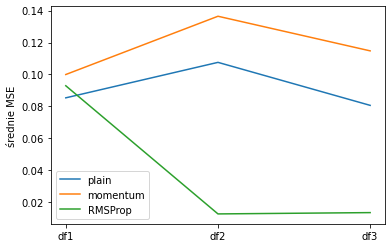

In [25]:
res_plot(r1)

### Wyniki - architektura nr 2

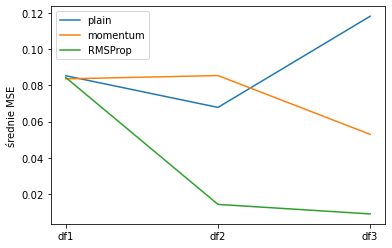

In [26]:
res_plot(r2)

## Wnioski
 - widzimy znaczącą korzyść z wykorzystania RMSProp
 - nie udało się w pełni potwierdzić przydatności momentum, jest to najpewniej spowodowane gorzej dobranymi parametrami
 - pojedyncze próby poza eksperymentem pozwolały zaobserwować przyspieszenie zbieżności przy korzystaniu z momentum